### Evaluate final U-Net models on CESM, FOCI and real world slp data

In [1]:
import os
import sys
sys.path.append('../reconstruct_missing_data')

from pathlib import Path
from json import dump, load

import numpy as np
import xarray as xr
from matplotlib import pyplot as plt

from data_loading import (
    find_data_files, 
    load_data_set, 
    get_anomalies, 
    clone_data, 
    create_missing_mask, 
    split_and_scale_data,
    area_mean_weighted,
    spatial_mask,
)
from models import build_unet_4conv
from indices import (
    southern_annular_mode_zonal_mean,
    north_atlantic_oscillation_station,
    north_pacific,
    el_nino_southern_oscillation_34,
    atlantic_multidecadal_oscillation,
)

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, concatenate, Conv1D, Conv2D, MaxPool2D, UpSampling2D, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow.keras.initializers as tfi
import tensorflow.keras.regularizers as tfr
from tensorflow.keras.utils import plot_model

# Suppress Tensorflow warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
# Set working directory, according to working directory in scripts:
os.chdir('/gxfs_work1/geomar/smomw511')

In [16]:
## Set paths to final models:

# # CESM
# paths_to_final_models=[
#     'GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_CESM_fixed_discrete_factor_1_final',
#     'GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_CESM_variable_discrete_factor_1_final',
#     'GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_CESM_variable_discrete_factor_2_final',
#     'GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_CESM_variable_discrete_factor_3_final',
#     'GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_CESM_optimal_discrete_factor_1_final',
# ]

# FOCI
paths_to_final_models=[
    'GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_FOCI_fixed_discrete_factor_1_final',
    'GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_FOCI_variable_discrete_factor_1_final',
    'GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_FOCI_variable_discrete_factor_2_final',
    'GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_FOCI_variable_discrete_factor_3_final',
    'GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_FOCI_optimal_discrete_factor_1_final',
]

# # realworld:
# paths_to_final_models=[
#     'GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_realworld_fixed_discrete_factor_1_final',
#     'GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_realworld_variable_discrete_factor_1_final',
#     'GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_realworld_variable_discrete_factor_2_final',
#     'GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_realworld_variable_discrete_factor_3_final',
#     'GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_realworld_optimal_from_CESM_discrete_factor_1_final',
#     'GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_realworld_optimal_from_FOCI_discrete_factor_1_final',
# ]



In [17]:
## Set shortnames for final models:

model_shortnames=[
    'mask: fixed',
    'mask: variable, factor: 1',
    'mask: variable, factor: 2',
    'mask: variable, factor: 3',
    'mask: optimal',
#    'mask: optimal from CESM',
#    'mask: optimal from FOCI',
]

In [21]:
# Load train and validation loss per sample for first model, to infer number of training and validation samples, 
# lat and lon, and number of missing value rates. Do this from first experiment, since it has augmentation factor 1:
n_train=np.load(Path(paths_to_final_models[0]) / 'train_loss_per_sample_all.npy').shape[-1]
n_val=np.load(Path(paths_to_final_models[0]) / 'val_loss_per_sample_all.npy').shape[-1]
lat=np.load(Path(paths_to_final_models[0]) / 'train_loss_map_all.npy').shape[1]
lon=np.load(Path(paths_to_final_models[0]) / 'train_loss_map_all.npy').shape[2]
n_missing=np.load(Path(paths_to_final_models[0]) / 'train_loss_per_sample_all.npy').shape[0]

# Initialize storage for parameters:
feature_all = []
feature_short_all = []
source_all = []
mask_type_all = []
missing_type_all = []
augmentation_factor_all = []
missing_values_all = []

# Initialize storage for reloaded results, for all models and missing rates.
train_loss_per_sample_all = np.zeros((len(paths_to_final_models),n_missing,n_train))
val_loss_per_sample_all = np.zeros((len(paths_to_final_models),n_missing,n_val))
train_loss_map_all = np.zeros((len(paths_to_final_models),n_missing,lat,lon))
val_loss_map_all = np.zeros((len(paths_to_final_models),n_missing,lat,lon))
ENSO_train_pred_all = np.zeros((len(paths_to_final_models),n_missing,n_train))
ENSO_val_pred_all = np.zeros((len(paths_to_final_models),n_missing,n_val))
ENSO_train_target_all = np.zeros((len(paths_to_final_models),n_missing,n_train))
ENSO_val_target_all = np.zeros((len(paths_to_final_models),n_missing,n_val))
AMO_train_pred_all = np.zeros((len(paths_to_final_models),n_missing,n_train))
AMO_val_pred_all = np.zeros((len(paths_to_final_models),n_missing,n_val))
AMO_train_target_all = np.zeros((len(paths_to_final_models),n_missing,n_train))
AMO_val_target_all = np.zeros((len(paths_to_final_models),n_missing,n_val))

# Loop over final models:
for i in range(len(paths_to_final_models)):
    
    # Get path to final model:
    path_to_final_model = paths_to_final_models[i]
    
    # Reload parameters for this experiment:
    with open(Path(path_to_final_model) / 'parameters.json', 'r') as f:
        parameters=load(f)

    # Store parameters:    
    feature_all.append(parameters['feature'])
    feature_short_all.append(parameters['feature_short'])
    source_all.append(parameters['source'])
    mask_type_all.append(parameters['mask_type'])
    missing_type_all.append(parameters['missing_type'])
    augmentation_factor_all.append(parameters['augmentation_factor'])
    missing_values_all.append(parameters['missing_values'])
    
    ## Reload results.
    ## Take augmentation factor into account: If data is used n times, only store every n-th sample.
    ## Like this, we have equal dimensions for all augmentation factors and include each target only once.
    
    # Get step size from augmentation factor:
    step = augmentation_factor_all[-1]

    # Get number of missing value rates:
    n_missing = len(missing_values_all[-1])

    ## Reload results and filter:
    # Consider all missing value rates, although optimal model has only 99.9%, 99% and 95% missing values. 
    # And take each sample only once.
    train_loss_per_sample_all[i,:n_missing]=np.load(Path(path_to_final_model) / 'train_loss_per_sample_all.npy')[:,np.arange(0,n_train*step,step)]
    val_loss_per_sample_all[i,:n_missing]=np.load(Path(path_to_final_model) / 'val_loss_per_sample_all.npy')[:,np.arange(0,n_val*step,step)]
    train_loss_map_all[i,:n_missing]=np.load(Path(path_to_final_model) / 'train_loss_map_all.npy')
    val_loss_map_all[i,:n_missing]=np.load(Path(path_to_final_model) / 'val_loss_map_all.npy')
    ENSO_train_pred_all[i,:n_missing]=np.load(Path(path_to_final_model) / 'ENSO_train_pred_all.npy')[:,np.arange(0,n_train*step,step)]
    ENSO_val_pred_all[i,:n_missing]=np.load(Path(path_to_final_model) / 'ENSO_val_pred_all.npy')[:,np.arange(0,n_val*step,step)]
    ENSO_train_target_all[i,:n_missing]=np.load(Path(path_to_final_model) / 'ENSO_train_target_all.npy')[:,np.arange(0,n_train*step,step)]
    ENSO_val_target_all[i,:n_missing]=np.load(Path(path_to_final_model) / 'ENSO_val_target_all.npy')[:,np.arange(0,n_val*step,step)]
    AMO_train_pred_all[i,:n_missing]=np.load(Path(path_to_final_model) / 'AMO_train_pred_all.npy')[:,np.arange(0,n_train*step,step)]
    AMO_val_pred_all[i,:n_missing]=np.load(Path(path_to_final_model) / 'AMO_val_pred_all.npy')[:,np.arange(0,n_val*step,step)]
    AMO_train_target_all[i,:n_missing]=np.load(Path(path_to_final_model) / 'AMO_train_target_all.npy')[:,np.arange(0,n_train*step,step)]
    AMO_val_target_all[i,:n_missing]=np.load(Path(path_to_final_model) / 'AMO_val_target_all.npy')[:,np.arange(0,n_val*step,step)]
 


### Indices (ENSO, AMO) on reconstructed vs. complete fields

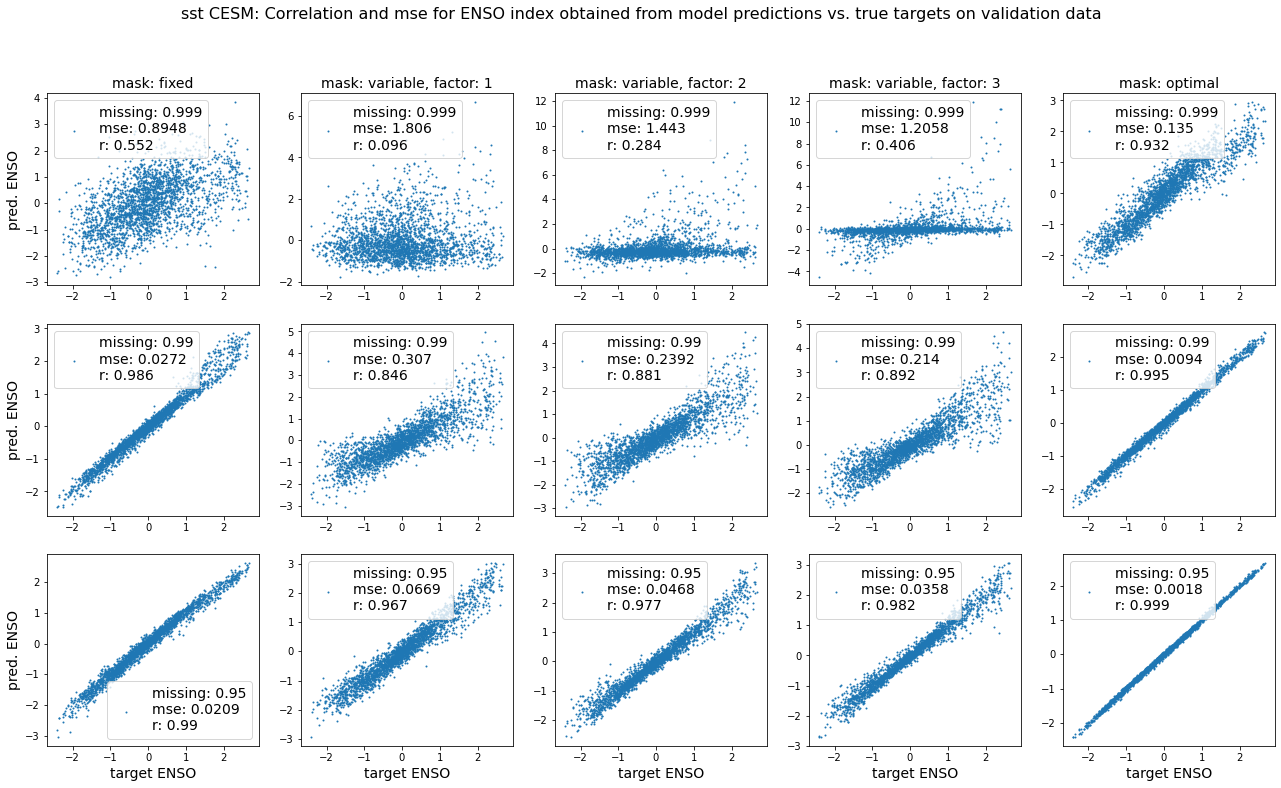

In [14]:
## sst CESM

## Show scatterplot of indices obtained from model predictions vs. true targets (=complete samples).

# Set number of missing rates to include:
n_missing_rates = 3

# Set number of samples to include:
n_samples = n_val

# Initialize plot for ENSO:
fig, axes = plt.subplots(n_missing_rates,len(model_shortnames),figsize=(22,12))

# Loop over rates of missing values:
for r in range(n_missing_rates):

    # Loop over models:
    for model_number in range(len(model_shortnames)):

        axes[r,model_number].scatter(ENSO_val_target_all[model_number,r,:n_samples], ENSO_val_pred_all[model_number,r,:n_samples], s=1,
                                   label=
                                     'missing: '+str(missing_values_all[model_number][r])+'\nmse: '+
                                     str(np.round(np.mean(np.mean((ENSO_val_target_all[model_number,r,:n_samples]-ENSO_val_pred_all[model_number,r,:n_samples])**2)),4))+'\nr: '+
                                     str(np.round(np.corrcoef(np.stack([ENSO_val_target_all[model_number,r,:n_samples],ENSO_val_pred_all[model_number,r,:n_samples]]))[0,1],3))
                                    )
        if r == 0:
            axes[r,model_number].set_title(model_shortnames[model_number], fontsize=14)
        if r == n_missing_rates-1:
            axes[r,model_number].set_xlabel('target ENSO', fontsize=14)
        if model_number == 0:
            axes[r,model_number].set_ylabel('pred. ENSO', fontsize=14)
        axes[r,model_number].legend(fontsize=14)

fig.suptitle('sst CESM: Correlation and mse for ENSO index obtained from model predictions vs. true targets on validation data', fontsize=16)
plt.show()

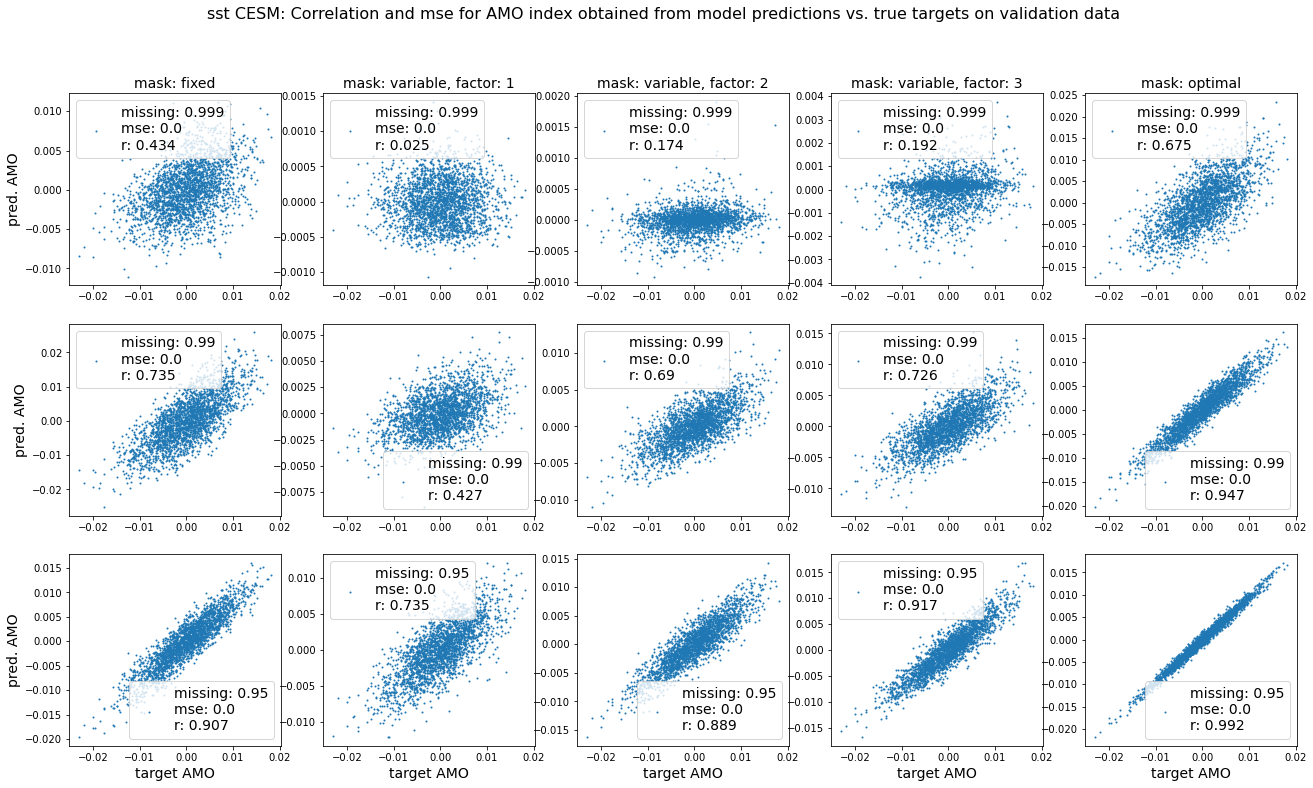

In [15]:
# Initialize plot for AMO:
fig, axes = plt.subplots(n_missing_rates,len(model_shortnames),figsize=(22,12))

# Loop over rates of missing values:
for r in range(n_missing_rates):

    # Loop over models:
    for model_number in range(len(model_shortnames)):

        axes[r,model_number].scatter(AMO_val_target_all[model_number,r,:n_samples], AMO_val_pred_all[model_number,r,:n_samples], s=1,
                                   label=
                                     'missing: '+str(missing_values_all[model_number][r])+'\nmse: '+
                                     str(np.round(np.mean(np.mean((AMO_val_target_all[model_number,r,:n_samples]-AMO_val_pred_all[model_number,r,:n_samples])**2)),4))+'\nr: '+
                                     str(np.round(np.corrcoef(np.stack([AMO_val_target_all[model_number,r,:n_samples],AMO_val_pred_all[model_number,r,:n_samples]]))[0,1],3))
                                    )
        if r == 0:
            axes[r,model_number].set_title(model_shortnames[model_number], fontsize=14)
        if r == n_missing_rates-1:
            axes[r,model_number].set_xlabel('target AMO', fontsize=14)
        if model_number == 0:
            axes[r,model_number].set_ylabel('pred. AMO', fontsize=14)
        axes[r,model_number].legend(fontsize=14)

fig.suptitle('sst CESM: Correlation and mse for AMO index obtained from model predictions vs. true targets on validation data', fontsize=16)
plt.show()

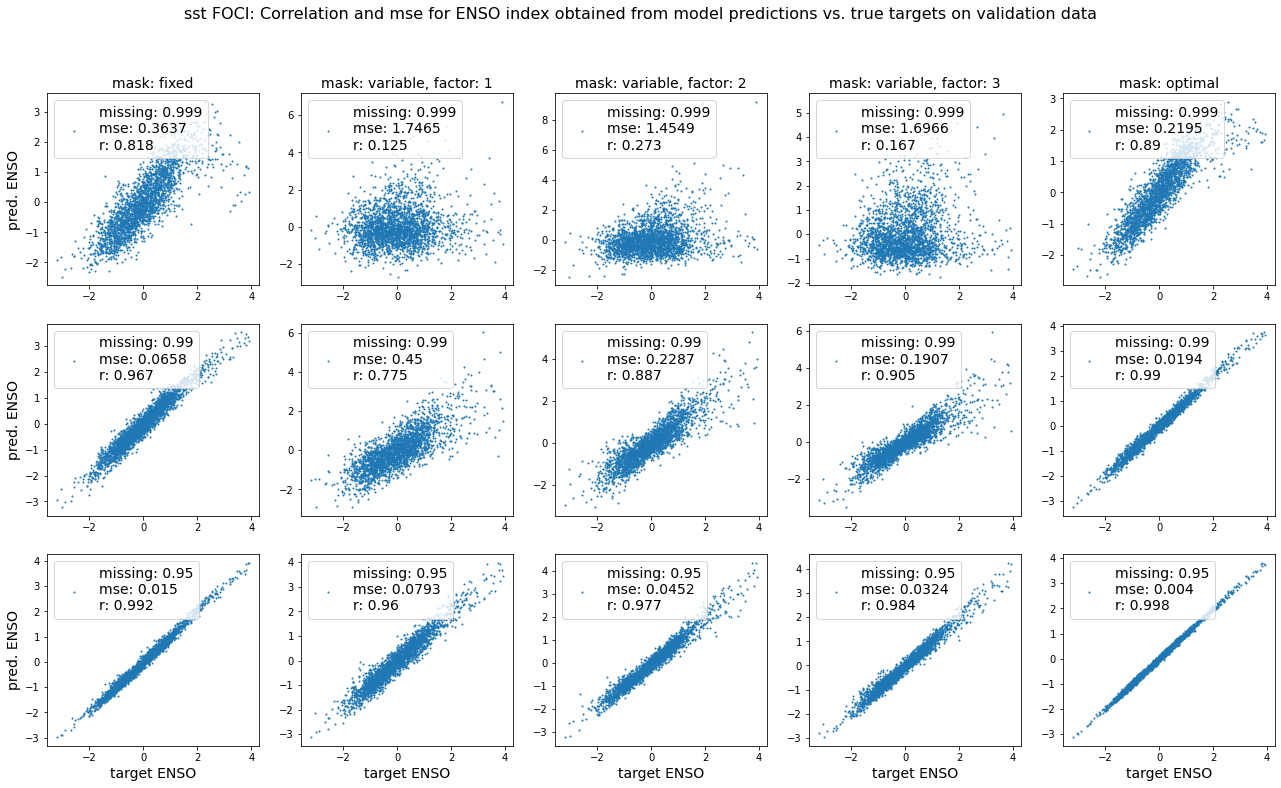

In [22]:
## sst FOCI

## Show scatterplot of indices obtained from model predictions vs. true targets (=complete samples).

# Set number of missing rates to include:
n_missing_rates = 3

# Set number of samples to include:
n_samples = n_val

# Initialize plot for ENSO:
fig, axes = plt.subplots(n_missing_rates,len(model_shortnames),figsize=(22,12))

# Loop over rates of missing values:
for r in range(n_missing_rates):

    # Loop over models:
    for model_number in range(len(model_shortnames)):

        axes[r,model_number].scatter(ENSO_val_target_all[model_number,r,:n_samples], ENSO_val_pred_all[model_number,r,:n_samples], s=1,
                                   label=
                                     'missing: '+str(missing_values_all[model_number][r])+'\nmse: '+
                                     str(np.round(np.mean(np.mean((ENSO_val_target_all[model_number,r,:n_samples]-ENSO_val_pred_all[model_number,r,:n_samples])**2)),4))+'\nr: '+
                                     str(np.round(np.corrcoef(np.stack([ENSO_val_target_all[model_number,r,:n_samples],ENSO_val_pred_all[model_number,r,:n_samples]]))[0,1],3))
                                    )
        if r == 0:
            axes[r,model_number].set_title(model_shortnames[model_number], fontsize=14)
        if r == n_missing_rates-1:
            axes[r,model_number].set_xlabel('target ENSO', fontsize=14)
        if model_number == 0:
            axes[r,model_number].set_ylabel('pred. ENSO', fontsize=14)
        axes[r,model_number].legend(fontsize=14)

fig.suptitle('sst FOCI: Correlation and mse for ENSO index obtained from model predictions vs. true targets on validation data', fontsize=16)
plt.show()

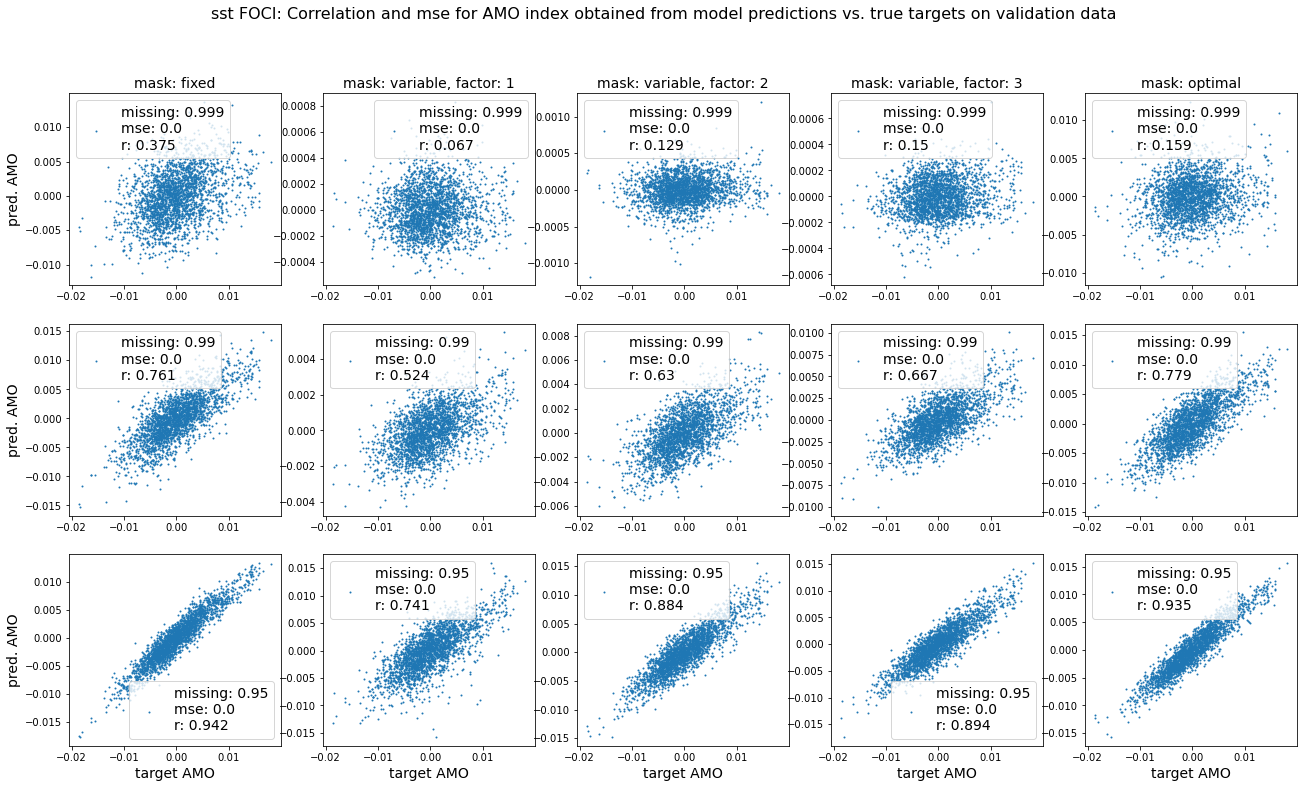

In [23]:
# Initialize plot for AMO:
fig, axes = plt.subplots(n_missing_rates,len(model_shortnames),figsize=(22,12))

# Loop over rates of missing values:
for r in range(n_missing_rates):

    # Loop over models:
    for model_number in range(len(model_shortnames)):

        axes[r,model_number].scatter(AMO_val_target_all[model_number,r,:n_samples], AMO_val_pred_all[model_number,r,:n_samples], s=1,
                                   label=
                                     'missing: '+str(missing_values_all[model_number][r])+'\nmse: '+
                                     str(np.round(np.mean(np.mean((AMO_val_target_all[model_number,r,:n_samples]-AMO_val_pred_all[model_number,r,:n_samples])**2)),4))+'\nr: '+
                                     str(np.round(np.corrcoef(np.stack([AMO_val_target_all[model_number,r,:n_samples],AMO_val_pred_all[model_number,r,:n_samples]]))[0,1],3))
                                    )
        if r == 0:
            axes[r,model_number].set_title(model_shortnames[model_number], fontsize=14)
        if r == n_missing_rates-1:
            axes[r,model_number].set_xlabel('target AMO', fontsize=14)
        if model_number == 0:
            axes[r,model_number].set_ylabel('pred. AMO', fontsize=14)
        axes[r,model_number].legend(fontsize=14)

fig.suptitle('sst FOCI: Correlation and mse for AMO index obtained from model predictions vs. true targets on validation data', fontsize=16)
plt.show()

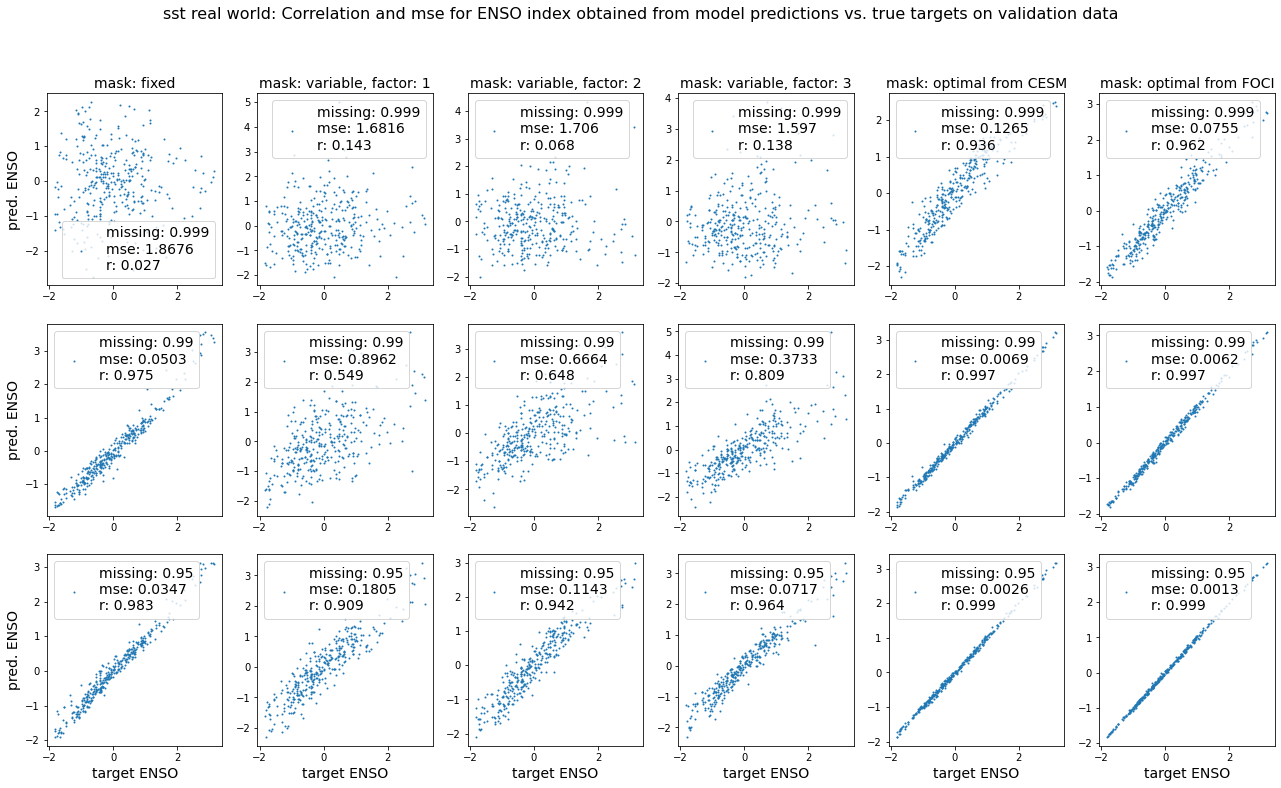

In [7]:
## sst real world

## Show scatterplot of indices obtained from model predictions vs. true targets (=complete samples).

# Set number of missing rates to include:
n_missing_rates = 3

# Set number of samples to include:
n_samples = n_val

# Initialize plot for ENSO:
fig, axes = plt.subplots(n_missing_rates,len(model_shortnames),figsize=(22,12))

# Loop over rates of missing values:
for r in range(n_missing_rates):

    # Loop over models:
    for model_number in range(len(model_shortnames)):

        axes[r,model_number].scatter(ENSO_val_target_all[model_number,r,:n_samples], ENSO_val_pred_all[model_number,r,:n_samples], s=1,
                                   label=
                                     'missing: '+str(missing_values_all[model_number][r])+'\nmse: '+
                                     str(np.round(np.mean(np.mean((ENSO_val_target_all[model_number,r,:n_samples]-ENSO_val_pred_all[model_number,r,:n_samples])**2)),4))+'\nr: '+
                                     str(np.round(np.corrcoef(np.stack([ENSO_val_target_all[model_number,r,:n_samples],ENSO_val_pred_all[model_number,r,:n_samples]]))[0,1],3))
                                    )
        if r == 0:
            axes[r,model_number].set_title(model_shortnames[model_number], fontsize=14)
        if r == n_missing_rates-1:
            axes[r,model_number].set_xlabel('target ENSO', fontsize=14)
        if model_number == 0:
            axes[r,model_number].set_ylabel('pred. ENSO', fontsize=14)
        axes[r,model_number].legend(fontsize=14)

fig.suptitle('sst real world: Correlation and mse for ENSO index obtained from model predictions vs. true targets on validation data', fontsize=16)
plt.show()

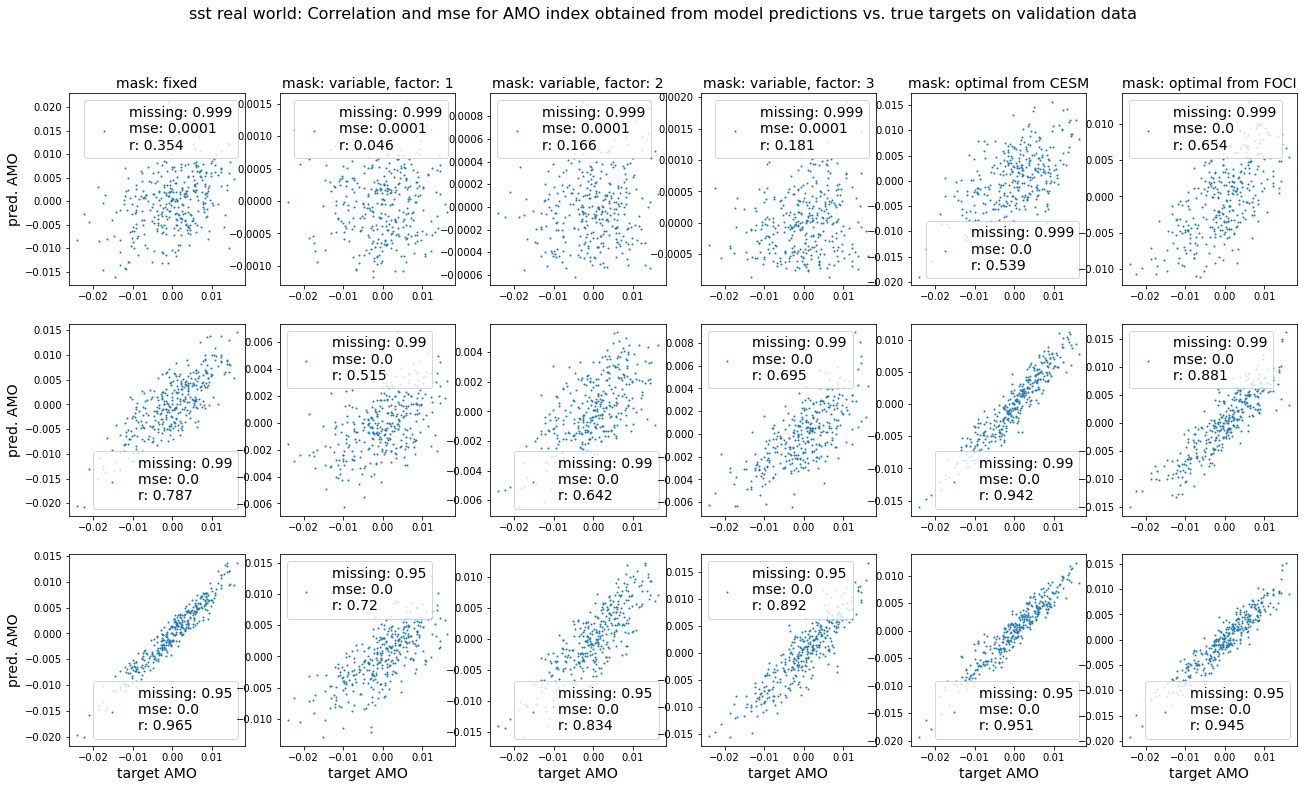

In [8]:
# Initialize plot for AMO:
fig, axes = plt.subplots(n_missing_rates,len(model_shortnames),figsize=(22,12))

# Loop over rates of missing values:
for r in range(n_missing_rates):

    # Loop over models:
    for model_number in range(len(model_shortnames)):

        axes[r,model_number].scatter(AMO_val_target_all[model_number,r,:n_samples], AMO_val_pred_all[model_number,r,:n_samples], s=1,
                                   label=
                                     'missing: '+str(missing_values_all[model_number][r])+'\nmse: '+
                                     str(np.round(np.mean(np.mean((AMO_val_target_all[model_number,r,:n_samples]-AMO_val_pred_all[model_number,r,:n_samples])**2)),4))+'\nr: '+
                                     str(np.round(np.corrcoef(np.stack([AMO_val_target_all[model_number,r,:n_samples],AMO_val_pred_all[model_number,r,:n_samples]]))[0,1],3))
                                    )
        if r == 0:
            axes[r,model_number].set_title(model_shortnames[model_number], fontsize=14)
        if r == n_missing_rates-1:
            axes[r,model_number].set_xlabel('target AMO', fontsize=14)
        if model_number == 0:
            axes[r,model_number].set_ylabel('pred. AMO', fontsize=14)
        axes[r,model_number].legend(fontsize=14)

fig.suptitle('sst real world: Correlation and mse for AMO index obtained from model predictions vs. true targets on validation data', fontsize=16)
plt.show()

### Find samples that clearly show outperformance of optimal models for reconstructing from ultra sparse inputs

In [7]:
## Prepare validation samples:

# Specify experiment:
model_config = 'unet_4conv'
feature = 'sea-level-pressure' # Choose either 'sea-level-pressure' or 'sea-surface-temperature' as feature.
feature_short = 'slp' # Free to set short name, to store results, e.g. 'slp' and 'sst'.
source = 'CESM' # Choose Earth System Model, either 'FOCI' or 'CESM'.
train_val_split = 0.8
scale_to = 'zero_one'

# Path to full data:
path_to_data = 'climate_index_collection/data/raw/2022-08-22/'

# Load data:
data = load_data_set(data_path=path_to_data, data_source_name=source)

# Select single feature and compute anomalies, using whole time span as climatology:
data = get_anomalies(feature=feature, data_set=data)

# Create synthetic missing_mask of ONEs, to load FULL validation samples:
missing_mask_1 = (np.ones(data.shape)==1)

# Get scaled validation inputs and targets. Note: Using missing_mask of ONEs, validation inputs and targets are 
# identical. Only difference is found in dimensionality: inputs have channel number (=1) as final dimension, targets don't.
_, val_input, _, val_target, train_min, train_max, _, _ = split_and_scale_data(
    data, 
    missing_mask_1,
    train_val_split, 
    scale_to
)

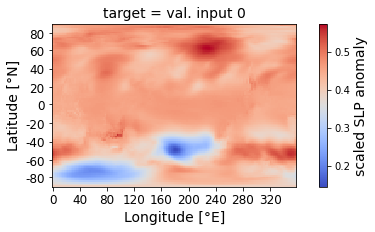

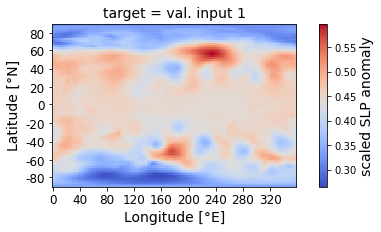

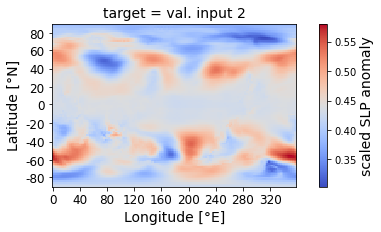

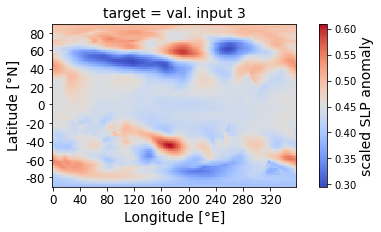

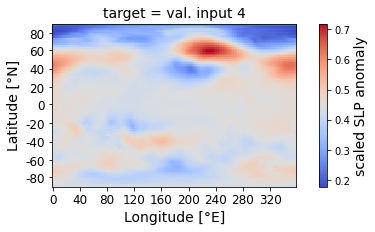

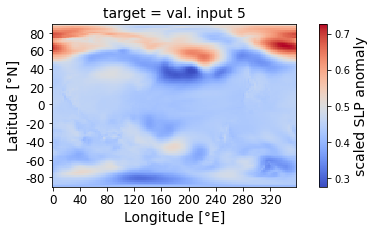

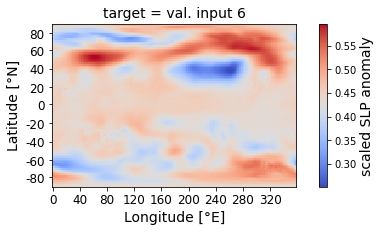

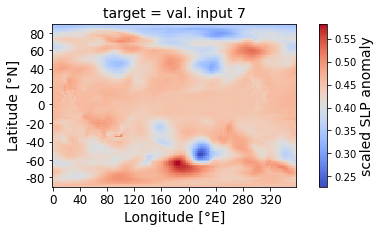

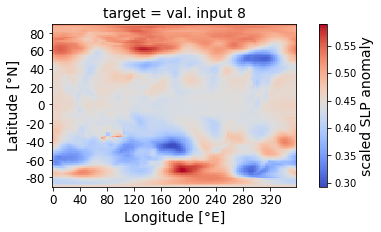

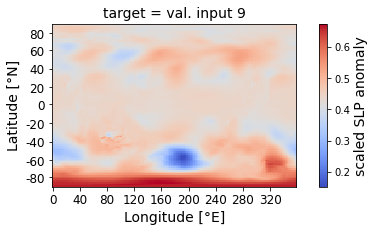

In [8]:
## Plot some validation targets (=complete samples):

# Specify number of samples to consider:
n_samples = 10

# Loop over samples:
for n in range(n_samples):
    
    ## Plot target:
    fig, ax = plt.subplots(figsize=(8, 3))
    im = plt.imshow(val_target[n], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
    cbar = plt.colorbar(im)
    cbar.set_label("scaled SLP anomaly", fontsize=14)
    plt.title('target = val. input '+str(n), fontsize=14)
    plt.xlabel('Longitude [°E]', fontsize=14)
    plt.ylabel('Latitude [°N]', fontsize=14)
    plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
    plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
    plt.show()

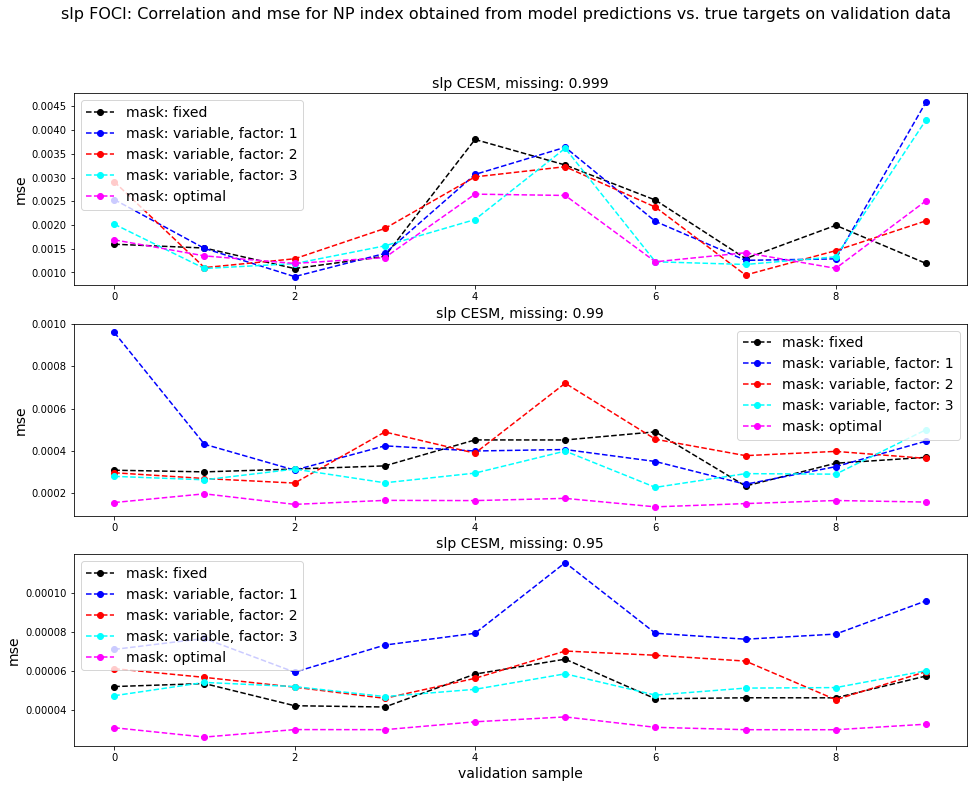

In [16]:
## Plot val. loss for several validation samples for all models and specified rates of missing values:

# Set number of missing rates to include:
n_missing_rates = 3

# Set colors and linestyles for individual models:
colors = ['black', 'blue', 'red', 'cyan', 'magenta']
linestyles = ['--', '--', '--', '--', '--']

# Initialize plot:
fig, axes = plt.subplots(n_missing_rates,1,figsize=(16,12))

# Loop over rates of missing values:
for r in range(n_missing_rates):

    # Loop over models:
    for model_number in range(len(model_shortnames)):

        axes[r].plot(
            val_loss_per_sample_all[model_number,r,:n_samples],
            color=colors[model_number],
            label=model_shortnames[model_number],
            marker = 'o', linestyle = linestyles[model_number],
        )
                
        axes[r].set_title(feature_short+' '+source+', missing: '+str(missing_values_all[model_number][r]), fontsize=14)
        if r == n_missing_rates-1:
            axes[r].set_xlabel('validation sample', fontsize=14)
        axes[r].set_ylabel('mse', fontsize=14)
        axes[r].legend(fontsize=14)

fig.suptitle('slp FOCI: Correlation and mse for NP index obtained from model predictions vs. true targets on validation data', fontsize=16)
plt.show()